# Supplementary Notebook 1: Filtering PTR values
## Paper: Novel Approach for Microbiome Analysis Using Bacterial Replication Rates and Causal Inference to Determine Resistome Potential
### Vitalii Stebliankin, Musfiqur Sazal, Camilo Valdes, Kalai Mathee, and GiriNarasimhan

#### Dataset: Gibson et al. (BioProject ID: PRJNA301903)

### 1. Explore PTR Distribution

/Users/stebliankin/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'PTR Distribution')

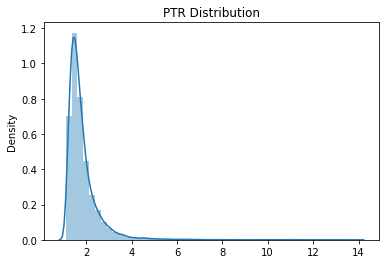

In [1]:
#create output folder
import os
out_dir = "analysis-out/1-FilteringPTR"
intermediate_dir = "{}/intermediate_files".format(out_dir)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
if not os.path.exists(intermediate_dir):
    os.mkdir(intermediate_dir)

# Read the PTR data:
import pandas as pd

# Reading PTR file for all bacteria
ptr_df = pd.read_csv("A-out/merged_ptr.csv", index_col=0)
ptr_df = ptr_df.T
ptr_df

# Getting list of all genomes:
all_genomes = list(ptr_df.columns)

# Visualize the data distribution
import seaborn as sns
import matplotlib.pyplot as plt

# Get the list of all PTR values:
all_ptr_list = []
for genome in all_genomes:
    all_ptr_list+= list(ptr_df[genome].dropna())

# Plot the distribution:
ax = sns.distplot(all_ptr_list)
plt.title("PTR Distribution")

Some of the PTR values are as larg as value 14. However, it is unlikely that any microbial subpopulation has on average 14 replication forks. Therefore, 2% larges PTR values were considered as outliers.

### 2 - Filter PTR outliers

/Users/stebliankin/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


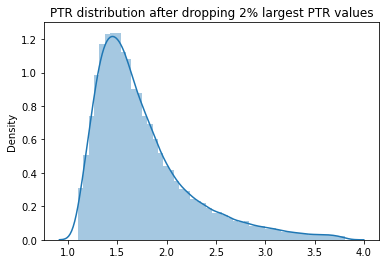

In [2]:
import numpy as np
drop_persent = 2
#Drop 2% largest PTR
all_ptr_list.sort() # sort in increasing order
top_ptr_values_index = int((len(all_ptr_list)/100) * (100-drop_persent))
cutoff_value = all_ptr_list[top_ptr_values_index-1]
all_ptr_list_prunned = all_ptr_list[0:top_ptr_values_index]


# Remove 2% largest from PTR Data Frame:
prunned_ptr_df = ptr_df.copy()
prunned_ptr_df[all_genomes] = ptr_df[all_genomes].applymap(lambda x: x if x<cutoff_value else np.nan)

# Save filtered dataframe:
prunned_ptr_df.to_csv(intermediate_dir+"/PTR_strain_filtered.csv")

# Plot new distribution:
ax = sns.distplot(all_ptr_list_prunned)
plt.title("PTR distribution after dropping {}% largest PTR values".format(drop_persent))
plt.show()

### 3 - Averaging PTR to species level
Here we obtain the average number of replication forks per one genome in the species population.

In [3]:
# Combine by species
    
ptr_merged_path = intermediate_dir+"/PTR_strain_filtered.csv"
taxonomy_file = "metadata/taxonomy.txt" # NCBI taxonomy. The file was obtained from RefSeqv.92. 
abundance_path = "A-out/merged_abundance.csv"

out_path = intermediate_dir+"/PTR_species_filtered.csv"

def merge_strains(ptr_df, taxonomy_file, abundance_path, out_path):
    ################################
    # Merge strains to species level
    ################################

    samples_list = list(ptr_df.columns)
    samples_list.remove("NZ")
    samples_list = [x.strip("\n") for x in samples_list]

    ptr_df.rename(columns=lambda x: x.strip("\n") + "_PTR", inplace=True)
    ptr_df.rename(columns={"NZ_PTR": "NZ"}, inplace=True)
    # Step 1 - Merge with abundance file
    abundance_df = pd.read_csv(abundance_path)

    abundance_df.rename(columns=lambda x: x.strip("\n") + "_abundance", inplace=True)
    abundance_df.rename(columns={"NZ_abundance": "NZ"}, inplace=True)

    nz_list = list(ptr_df["NZ"])
    abundance_df = abundance_df[abundance_df["NZ"].isin(nz_list)]
    # ptr_df = ptr_df.fillna(0) # convenient for computation. Note: Change for 1 later
    abundance_df = abundance_df.fillna(0)
    abundance_df = abundance_df.reset_index(drop=True)

    ptr_df = ptr_df.merge(abundance_df, on="NZ", how="left")

    # Step 2 - Merge NZ with taxa species name
    taxonomy_df = pd.read_csv(taxonomy_file, sep="\t")

    taxonomy_df["NZ"] = taxonomy_df["NZ"].apply(lambda x: x.split(".")[0])
    taxonomy_cols = list(taxonomy_df.columns)
    ptr_df = taxonomy_df.merge(ptr_df, on="NZ", how="right")

    species_list = list(ptr_df["species"].unique())

    # Step 3 - Combine taxa

    # create dictionary with new values
    ptr_dict = {}
    ptr_dict["sample"] = samples_list

    previous_species = ""

    k = -1
    columns_list = []
    for specie in species_list:
        print("Merging " + specie + "...")
        if isinstance(specie, str):
            tmp_df = ptr_df[ptr_df["species"] == specie]
            ptr_dict[specie + "#abundance"] = []
            ptr_dict[specie + "#PTR"] = []
            for sample in ptr_dict["sample"]:
                tmp_df_sample = tmp_df[["NZ", "species", sample + "_PTR", sample + "_abundance"]]
                if len(tmp_df_sample)>0:
                    total_abundance_not_droppped = tmp_df_sample[sample + "_abundance"].sum()
                else:
                    total_abundance_not_droppped=0
                tmp_df_sample = tmp_df_sample.dropna()
                total_abundance = tmp_df_sample[sample + "_abundance"].sum()

                if len(tmp_df_sample) > 0:
                    tmp_df_sample[sample + "_cumulative"] = tmp_df.apply(
                        lambda row: row[sample + "_abundance"] * row[sample + "_PTR"] / total_abundance, axis=1)
                    ptr = tmp_df_sample[sample + "_cumulative"].sum()
                    ptr_dict[specie + "#abundance"].append(total_abundance_not_droppped)
                    ptr_dict[specie + "#PTR"].append(ptr)

                else:
                    ptr_dict[specie + "#abundance"].append(total_abundance_not_droppped)
                    ptr_dict[specie + "#PTR"].append(np.nan)
        columns_list.append(specie + "#abundance")
        columns_list.append(specie + "#PTR")

    new_ptr_df = pd.DataFrame.from_dict(ptr_dict)
    new_ptr_df = new_ptr_df[["sample"]+ columns_list]
    new_ptr_df.to_csv(out_path, index=False)
    return new_ptr_df


ptr_df = pd.read_csv(ptr_merged_path, index_col=0)
ptr_df = ptr_df.T
ptr_df["NZ"] = ptr_df.index
ptr_df = ptr_df.reset_index(drop=True)
ptr_df = merge_strains(ptr_df, taxonomy_file, abundance_path, out_path)

Merging Enterococcus faecalis...
Merging Streptococcus thermophilus...
Merging Bifidobacterium breve...
Merging Klebsiella michiganensis...
Merging Klebsiella oxytoca...
Merging Escherichia coli...
Merging Bifidobacterium scardovii...
Merging Klebsiella sp. M5al...
Merging Streptococcus salivarius...
Merging Serratia marcescens...
Merging Klebsiella aerogenes...
Merging Streptococcus vestibularis...
Merging Streptococcus sp. FDAARGOS_192...
Merging Serratia sp. FS14...
Merging Erysipelotrichaceae bacterium I46...
Merging Streptococcus equinus...
Merging Serratia sp. SSNIH1...
Merging Streptococcus agalactiae...
Merging Enterobacter cloacae...
Merging Salmonella enterica...
Merging Enterobacter hormaechei...
Merging Streptococcus sp. FDAARGOS_521...
Merging Veillonella parvula...
Merging Enterobacter sp. DKU_NT_01...
Merging Streptococcus sp. FDAARGOS_520...
Merging Enterobacter sp. CRENT-193...
Merging Streptococcus sp. 'group B'...
Merging Neisseria sicca...
Merging Neisseria subflava

### 4 - Compute Average PTR across samples

In [4]:
import pandas as pd
import numpy as np


ptr_file = intermediate_dir+"/PTR_species_filtered.csv"
ptr_combined = intermediate_dir+"/PTR_sample_filtered.csv" #output
metadata_path = "metadata/metadata_gibson.csv" #Metadata for Gibson et al. dataset

df = pd.read_csv(ptr_file, index_col=0)

relevant_coluns = ["sample", "Day_of_Life", "PostMenst_Age", "Individual", "Gestational_Age",
                   "Birthweight", "Gentamicin", "Cefazolin","Ampicillin", "Trimethoprim-Sulfamathoxazole", "Meropenem",
                   "Vancomycin", "Ticarcillin-Clavulanate", "Clindamycin", "Cefotaxime", "Total_abx", "r_Gentamicin",
                   "r_Meropenem", "r_Ticarcillin-Clavulanate", "r_Vancomycin", "r_Ampicillin",
                   "r_Cefotaxime","r_TOTAL","Human_Milk","Maternal_Milk", "Donor_Milk", "Formula","Fortification","Vitamin_A",
                   "Caffeine","Iron","Furosemide_Lasix","m_ampicillin","m_ceftriaxone","m_azithromycin",
                   "m_amoxicillin", "m_cefazolin","m_erythromycin","m_gentamicin","m_penicillin","m_vancomycin",
                   "m_clindamycin","m_cefotaxime", "dur_membrane_rupture", "CRIB II Score","Total Antibiotic Days", "Antibiotic_Treatment","Antibiotic_Treatment_unfiltered", "Cohort"]

all_columns = df.columns
species_list = []
# Get the list of unique species:
for col in all_columns:
    species = col.replace("#abundance", "").replace("#PTR", "")
    if species not in species_list:
        species_list.append(species)

def combine(row, species_list):
    total_abundance = 0
    cum_ptr = 0
    for species in species_list:
        #try:
        ptr = row[species+"#PTR"]
        abundance = row[species+"#abundance"]
        if (not np.isnan(ptr)) and (not np.isnan(abundance)):
            cum_ptr += ptr*abundance
            total_abundance += abundance
            pass
            pass
    if total_abundance==0:
        return np.nan
    else:
        return cum_ptr/total_abundance

df["AveragePTR"] = df.apply(lambda row: combine(row, species_list), axis=1)
df["sample"] = df.index
df = df.reset_index(drop=True)
# Combine with metadata:
metadata_df = pd.read_csv(metadata_path)

df = metadata_df.merge(df, how="right", on="sample")

df = df[["AveragePTR"] + relevant_coluns]

df.to_csv(ptr_combined, index=False)

### 5 - Select Major Species
Select taxa for which we have PTR values in at least 20 samples

In [5]:
in_file = intermediate_dir+"/PTR_species_filtered.csv"
metadata_file = intermediate_dir+"/PTR_sample_filtered.csv"

out_file_major = out_dir+"/PTR_species_filtered_metadata_major.csv"
out_file_all = out_dir+"/PTR_species_filtered_metadata.csv"

cutoff = 20

# Filter taxa that have less than "cutoff" values:

# Get list of species:
ptr_df = pd.read_csv(in_file)
columns = ptr_df.columns
species_list=[]
for col in columns:
    if "PTR" in col:
        species = col.replace("#PTR", "")
        species_list.append(species)
print("There are {} species in the dataset.".format(len(species_list)))

def filter_major(cutoff, out_file, ptr_df):
    # Filter out the species that present in less than "cutoff" samples:
    updated_n_sp=0
    for sp in species_list:
        tmp_df = ptr_df[ptr_df[sp+"#PTR"].notnull()]
        if len(tmp_df)<cutoff:
            ptr_df = ptr_df.drop(sp+"#PTR", axis=1)
            ptr_df = ptr_df.drop(sp + "#abundance", axis=1)
        else:
            updated_n_sp+=1
        # sns.regplot(data=tmp_df, x=sp+"#PTR", y=sp+"#abundance")
        # plt.show()
    pass
    pass
    print("Number of selected species: {}".format(updated_n_sp))
    # Clinical variables:
    metadata_df = pd.read_csv(metadata_file)

    merged_df = metadata_df.merge(ptr_df, on="sample", how="right")
    merged_df = merged_df[merged_df["Day_of_Life"].notnull()]
    merged_df = merged_df.drop_duplicates()
    merged_df.to_csv(out_file, index=False)

#    merged_df = merged_df.fillna(1)
    merged_df.to_csv(out_file, index=False)
    return merged_df

filter_major(0, out_file_all, ptr_df)
merged_df = filter_major(cutoff, out_file_major, ptr_df)

There are 154 species in the dataset.
Number of selected species: 154
Number of selected species: 25


In [6]:
merged_df

,AveragePTR,sample,Day_of_Life,PostMenst_Age,Individual,Gestational_Age,Birthweight,Gentamicin,Cefazolin,Ampicillin,...,Enterobacter asburiae#abundance,Enterobacter asburiae#PTR,Bifidobacterium longum#abundance,Bifidobacterium longum#PTR,Clostridium perfringens#abundance,Clostridium perfringens#PTR,Klebsiella variicola#abundance,Klebsiella variicola#PTR,Enterobacteriaceae bacterium S05#abundance,Enterobacteriaceae bacterium S05#PTR
0,1.282566,SRX1551675,14.7,27.1,234.01,25.0,830.0,0.0,0.0,2.0,...,0.000824,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
1,1.616727,SRX1552133,22.9,34.3,294.01,31.0,1440.0,0.0,0.0,2.0,...,0.000000,NaN,0.008547,NaN,0.000000,NaN,0.001663,NaN,0.000135,NaN
2,1.542323,SRX1552131,39.6,34.7,37.02,29.0,1530.0,2.0,0.0,2.0,...,0.000000,NaN,0.000000,NaN,0.011124,NaN,0.021058,NaN,0.001424,NaN
4,1.448789,SRX1552127,82.2,35.7,175.01,24.0,730.0,10.0,3.0,12.0,...,0.001812,NaN,0.000000,NaN,0.000000,NaN,0.000290,NaN,0.000000,NaN
5,1.580480,SRX1552125,10.9,27.6,363.01,26.0,890.0,2.0,0.0,2.0,...,0.000000,NaN,0.000000,NaN,0.000777,NaN,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,1.500532,SRX1551345,29.4,35.2,76.03,31.0,1710.0,2.0,0.0,2.0,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000577,NaN,0.000000,NaN
397,1.373954,SRX1551343,21.2,30.0,286.02,27.0,990.0,2.0,0.0,3.0,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
398,1.778688,SRX1551341,18.3,32.6,144.01,30.0,1470.0,6.0,0.0,1.0,...,0.000023,NaN,0.000000,NaN,0.000000,NaN,0.026919,1.426859,0.000527,NaN
399,1.398331,SRX1551339,23.4,34.3,139.01,31.0,1260.0,2.0,0.0,2.0,...,0.001131,NaN,0.000000,NaN,0.000000,NaN,0.001169,NaN,0.000000,NaN


In [7]:
# Re-normalize the abundance (some species for which PTR was not computed have been droped)
all_cols = merged_df.columns
abundance_cols = []
for x in all_cols:
    if "#abundance" in x:
        abundance_cols.append(x)

abundance_df = merged_df[abundance_cols]
abundance_df.index = merged_df['sample']
    
abundance_df_t = abundance_df.T
for col in abundance_df_t.columns:
    tmp_sum = abundance_df_t[col].sum()
    abundance_df_t[col] = abundance_df_t[col].apply(lambda x: x/tmp_sum)
abundance_df_t
abundance_df_t['avg'] = abundance_df_t.mean(axis=1)
abundance_df = abundance_df_t.T
abundance_df

,Enterococcus faecalis#abundance,Klebsiella michiganensis#abundance,Klebsiella oxytoca#abundance,Escherichia coli#abundance,Klebsiella sp. M5al#abundance,Klebsiella aerogenes#abundance,Enterobacter cloacae#abundance,Enterobacter hormaechei#abundance,Veillonella parvula#abundance,Enterobacter sp. DKU_NT_01#abundance,...,Citrobacter#abundance,Klebsiella pneumoniae#abundance,Klebsiella quasipneumoniae#abundance,Enterobacter roggenkampii#abundance,Enterobacter sp. HK169#abundance,Enterobacter asburiae#abundance,Bifidobacterium longum#abundance,Clostridium perfringens#abundance,Klebsiella variicola#abundance,Enterobacteriaceae bacterium S05#abundance
sample,,,,,,,,,,,,,,,,,,,,,
SRX1551675,0.634112,0.000000,0.000000,0.011582,0.000000,0.000000,0.115265,0.143073,0.000000,0.002286,...,0.000000,0.000000,0.000000,0.002448,0.000000,0.002333,0.000000,0.000000,0.000000,0.000000
SRX1552133,0.059566,0.062566,0.263032,0.174744,0.005325,0.016458,0.032627,0.021527,0.100593,0.000767,...,0.000000,0.148502,0.009024,0.000000,0.000000,0.000000,0.086968,0.000000,0.016922,0.001378
SRX1552131,0.166527,0.004747,0.019932,0.000000,0.001315,0.392515,0.000666,0.000000,0.013319,0.000000,...,0.000000,0.305401,0.024194,0.000000,0.000665,0.000000,0.000000,0.023157,0.043835,0.002965
SRX1552127,0.031047,0.001626,0.005286,0.012757,0.000153,0.002253,0.402611,0.395630,0.018928,0.006301,...,0.000330,0.072674,0.001233,0.017610,0.000100,0.012935,0.000000,0.000000,0.002071,0.000000
SRX1552125,0.373974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002663,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX1551343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SRX1551341,0.003240,0.000607,0.007682,0.112521,0.000000,0.021701,0.008625,0.003806,0.000000,0.000000,...,0.000000,0.621984,0.038287,0.000000,0.000000,0.000149,0.000000,0.000000,0.177180,0.003470
SRX1551339,0.301172,0.007098,0.016946,0.005055,0.001093,0.022306,0.249006,0.236430,0.000000,0.004137,...,0.000460,0.101204,0.005131,0.012248,0.000459,0.009573,0.000000,0.000000,0.009889,0.000000


In [8]:
for col in abundance_cols:
    print('"{}",'.format(col))

"Enterococcus faecalis#abundance",
"Klebsiella michiganensis#abundance",
"Klebsiella oxytoca#abundance",
"Escherichia coli#abundance",
"Klebsiella sp. M5al#abundance",
"Klebsiella aerogenes#abundance",
"Enterobacter cloacae#abundance",
"Enterobacter hormaechei#abundance",
"Veillonella parvula#abundance",
"Enterobacter sp. DKU_NT_01#abundance",
"Enterobacter sp. CRENT-193#abundance",
"Staphylococcus epidermidis#abundance",
"Enterococcus faecium#abundance",
"Bacteroides fragilis#abundance",
"Citrobacter freundii#abundance",
"Citrobacter#abundance",
"Klebsiella pneumoniae#abundance",
"Klebsiella quasipneumoniae#abundance",
"Enterobacter roggenkampii#abundance",
"Enterobacter sp. HK169#abundance",
"Enterobacter asburiae#abundance",
"Bifidobacterium longum#abundance",
"Clostridium perfringens#abundance",
"Klebsiella variicola#abundance",
"Enterobacteriaceae bacterium S05#abundance",


In [9]:
merged_df.index = merged_df['sample']
for x in all_cols:
    if "#abundance" in x:
        merged_df[x] = abundance_df[x]
merged_df.to_csv(out_dir+"/PTR_species_filtered_metadata_major.csv", index=False)
merged_df

,AveragePTR,sample,Day_of_Life,PostMenst_Age,Individual,Gestational_Age,Birthweight,Gentamicin,Cefazolin,Ampicillin,...,Enterobacter asburiae#abundance,Enterobacter asburiae#PTR,Bifidobacterium longum#abundance,Bifidobacterium longum#PTR,Clostridium perfringens#abundance,Clostridium perfringens#PTR,Klebsiella variicola#abundance,Klebsiella variicola#PTR,Enterobacteriaceae bacterium S05#abundance,Enterobacteriaceae bacterium S05#PTR
sample,,,,,,,,,,,,,,,,,,,,,
SRX1551675,1.282566,SRX1551675,14.7,27.1,234.01,25.0,830.0,0.0,0.0,2.0,...,0.002333,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
SRX1552133,1.616727,SRX1552133,22.9,34.3,294.01,31.0,1440.0,0.0,0.0,2.0,...,0.000000,NaN,0.086968,NaN,0.000000,NaN,0.016922,NaN,0.001378,NaN
SRX1552131,1.542323,SRX1552131,39.6,34.7,37.02,29.0,1530.0,2.0,0.0,2.0,...,0.000000,NaN,0.000000,NaN,0.023157,NaN,0.043835,NaN,0.002965,NaN
SRX1552127,1.448789,SRX1552127,82.2,35.7,175.01,24.0,730.0,10.0,3.0,12.0,...,0.012935,NaN,0.000000,NaN,0.000000,NaN,0.002071,NaN,0.000000,NaN
SRX1552125,1.580480,SRX1552125,10.9,27.6,363.01,26.0,890.0,2.0,0.0,2.0,...,0.000000,NaN,0.000000,NaN,0.002663,NaN,0.000000,NaN,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRX1551345,1.500532,SRX1551345,29.4,35.2,76.03,31.0,1710.0,2.0,0.0,2.0,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.002602,NaN,0.000000,NaN
SRX1551343,1.373954,SRX1551343,21.2,30.0,286.02,27.0,990.0,2.0,0.0,3.0,...,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
SRX1551341,1.778688,SRX1551341,18.3,32.6,144.01,30.0,1470.0,6.0,0.0,1.0,...,0.000149,NaN,0.000000,NaN,0.000000,NaN,0.177180,1.426859,0.003470,NaN
